# Stock Market Predictions - LSTM Neural Networks

###### Ignacio Antequera Sanchez

# 0. Introduction
---

Hello Everyone! 

Welcome to my Stock Market Predictions Project using ```LSTM Neural Networks```. My name is Ignacio Antequera and in this notebook, I will be sharing with you how we can use a time-series model known as Long Short-Term Memory.

The logic behind this project is to use machine learning models that can look at the history of a sequence of data and correctly predict what the future elements of the sequence are going to be. This is where ```time series modeling``` comes in.

> Disclaimer: This project is solely for learning purposes and does not serve as a financial advisor. Stock market prices are highly unpredictable and volatile. This means that there are no consistent patterns in the data that allow you to model stock prices over time near-perfectly.

The objective of this project id to see if we can model the data, so that the predictions we make correlate with the actual behavior of the data. In other words, we don't need the exact stock values of the future, but the stock price movements

### Import Libraries:

In [1]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 1. Downloading the data
---

There are two ways we can access data for this project:

- `Alpha Vnatage Stock API`: This API contains realtime and historical stock market data. This is a reliable source for historical market data that offers a wide range of financial datasets.

    - Since we going to make use of the American Airlines Stock market prices to make your predictions, we set the ticker to `"AAL"`. 
    - We define a `url_string`, which will return a JSON file with all the stock market data for American Airlines within the last 20 years.
    - We define a `file_to_save`, which will be the file to which we save the data. 
    - We will use the `ticker` variable that we defined beforehand to help name this file.
    - Next, we are going to specify a condition: if you haven't already saved data.
    - We will go ahead and grab the data from the URL that we set in `url_string`
    - We'll store the date, low, high, volume, close, open values to a pandas DataFrame df. 
    - We will save it to file_to_save. However, if the data is already there, we'll just load it from the CSV. (This is useful for future runs of the code)

- [Kaggle](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs): This is a huge stock market dataset that contains   Historical daily prices and volumes of all U.S. stocks and ETFs. For the purposes of this demo, I will be using this option. I will be working on HP's stock since it contains a good amount of data that will serve us good for our this demo. However, you may access other demos on this repository where I will be analyzing stocks whose data has been retrieved from Alphavantage. Note that if we select this option, you will need to copy the Stocks folder in the zip file to your project home folder.

In [2]:
# Select the method that best suits you.
data_source = 'Kaggle'

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '7F6B6RZW9SPFQE8N'

    # Apple stock market prices
    ticker = "AAL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # Grab the data from the url
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            # Store date, low, high, volume, close, open values to a Pandas DataFrame
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:

    # ====================== Loading Data from Kaggle ==================================
    # We will be using HP's data. Feel free to experiment with other data.
    # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')

Loaded data from the Kaggle repository


# 2. Data Exploration
---

Now that we have our data properly stored, let's take a quick look at its structure. But first, since we are going to be working on time series modelling, we need to make sure that the data is sorted by date.

In [3]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385


# 3. Data Visualization
---

Now, let's take a look at what sort of data we have. We are interested in data with various patterns occurring over time.

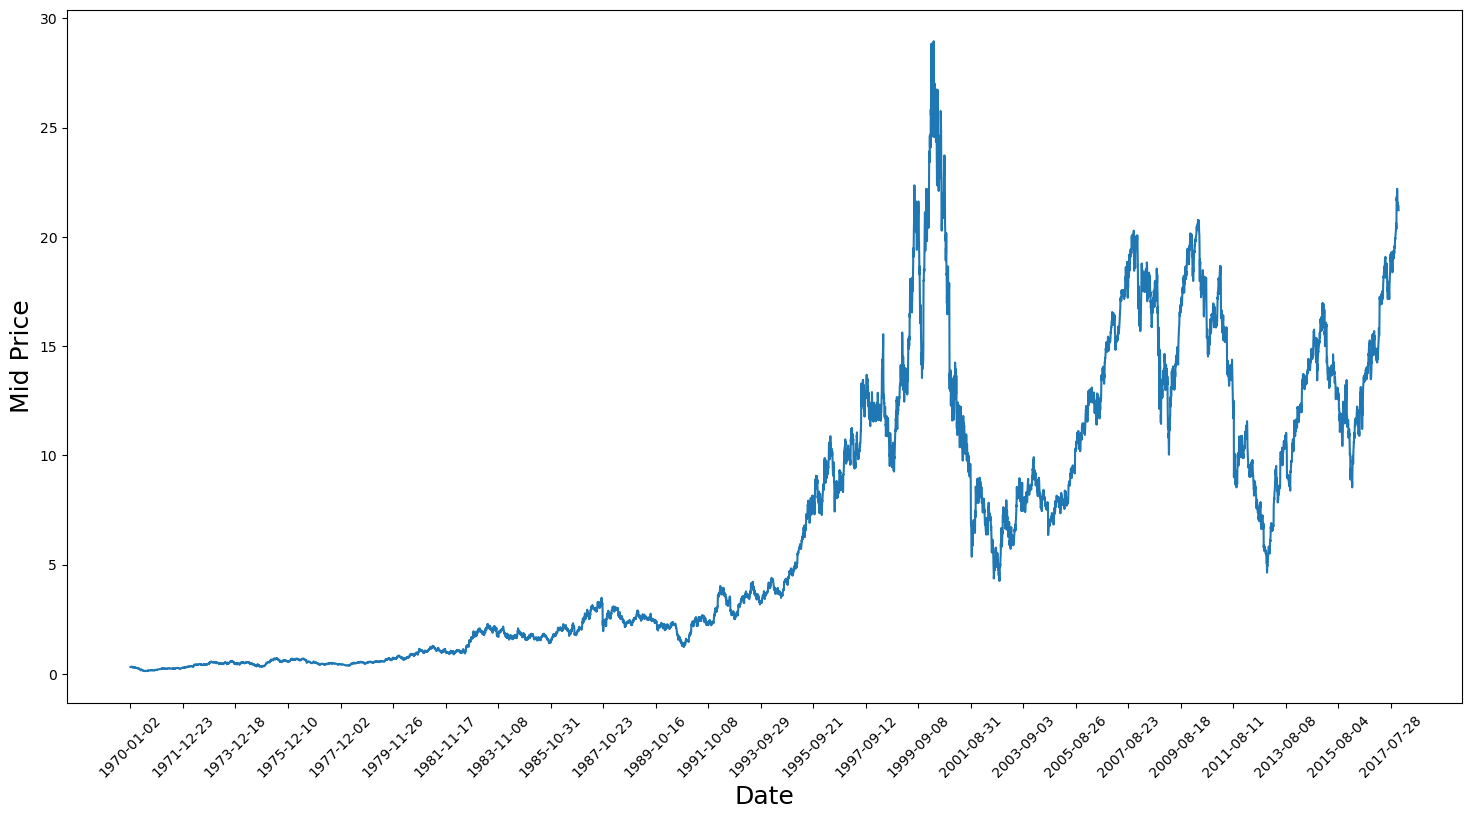

In [4]:
# Set the size of the figure
plt.figure(figsize = (18,9))

# Create the line plot
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)

# Set the x-axis tick marks to be every 500 rows in df
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)

# Set the x-axis and y-axis labels
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)

# Display the plot
plt.show()

This graph provides valuable insights into various aspects. The reason we chose this particular company over others is due to the diverse range of behaviors exhibited by its stock prices over time, making it an excellent candidate for robust learning and providing ample opportunities to evaluate prediction accuracy across different scenarios.

It's worth noting that the stock prices around 2017 exhibit significantly higher values and greater fluctuations compared to those around the 1970s. Therefore, it's essential to ensure consistent value ranges for the data throughout the entire time frame. This normalization process will be addressed during the data normalization phase.

# 4. Splitting Data into Training set and Test set
---

We will use the mid price calculated by taking the average of the highest and lowest recorded prices on a day.

In [5]:
# Calculate the mid prices from the highest and lowest
high_prices = df['High'].values
low_prices = df['Low'].values
mid_prices = (high_prices+low_prices)/2.0

This will allow us to split the training data and test data.

In [6]:
# Define the features (X) and target variable (y)
X = df.index.values.reshape(-1, 1)  # Using index as a feature for demonstration purposes
y = mid_prices

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (9660, 1) (9660,)
Testing set shape: (2415, 1) (2415,)


It appears that our data has been properly split into training and testing sets, with the training set consisting of 9660 samples and the testing set consisting of 2415 samples, each containing one feature. Additionally, both the training and testing sets have corresponding target variables with the same number of samples.

# 5. Normalizing the Data
---

Before proceeding with training our model, it's important to normalize the data to ensure that all features are on a similar scale. Normalization helps in improving the convergence speed and performance of machine learning algorithms, especially those sensitive to feature scales.

Once the data is normalized, we can proceed with training your model using the training set and evaluating its performance on the normalized testing set.

In [7]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform scaler on training data
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.transform(y_train.reshape(-1, 1))  # Reshape if y_train is 1D

# Transform testing data using the same scaler
X_test_scaled = scaler.transform(X_test)
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))  # Reshape if y_test is 1D

This scaler ensures that the data is scaled to be between 0 and 1

Due to the observation we made earlier, that is, different time periods of data have different value ranges, we will normalize the data by splitting the full series into windows. If we don't do this, the earlier data will be close to 0 and will not add much value to the learning process. In this case we are going to split the data into 4 windows of same size.

In [8]:
# Calculate the window size based on the training set size
smoothing_window_size = len(X_train) // 4

# Train the Scaler with training data and smooth data
for di in range(0, len(X_train), smoothing_window_size):
    scaler.fit(X_train[di:di+smoothing_window_size])
    X_train[di:di+smoothing_window_size] = scaler.transform(X_train[di:di+smoothing_window_size])

# Normalize the last bit of remaining training data
if len(X_train) % smoothing_window_size != 0:
    scaler.fit(X_train[di+smoothing_window_size:])
    X_train[di+smoothing_window_size:] = scaler.transform(X_train[di+smoothing_window_size:])

Reshape the data back to the shape of [data_size]

In [9]:
# Reshape both train and test data
X_train = X_train.reshape(-1)

# Normalize test data
X_test = scaler.transform(X_test).reshape(-1)

We can now smooth the data using the exponential moving average. This helps you to get rid of the inherent raggedness of the data in stock prices and produce a smoother curve.

In [10]:
EMA = 0.0  # Initialize exponential moving average (EMA) value
gamma = 0.1  # Smoothing factor (adjust as needed)

# Calculate the number of data points in the training set (80% of total data)
training_set_size = int(len(X_train) * 0.8)

# Iterate over the training data
for ti in range(training_set_size):
    # Update exponential moving average (EMA) using current data point and previous EMA value
    EMA = gamma * X_train[ti] + (1 - gamma) * EMA
    # Replace original data point with smoothed EMA value
    X_train[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([X_train, X_test], axis=0)

# 6. One-Step Ahead Prediction via Averaging
---

We can better understand the difficulty of this problem by first trying to model this as an average calculation problem. Averaging mechanisms allow us to predict (often one time step ahead) by representing the future stock price as an average of the previously observed stock prices. Doing this for more than one time step can produce quite bad results. 

However, we are going to look at two averaging techniques below:
- `Standard Averaging`
- `Exponential Moving Average`

We will evaluate  the results produced by the two algorithms both qualitatively (visual inspection) and quantitatively (Mean Squared Error).

### Standard Averaging

In this method, you will try to predict the future stock market prices as an average of the previously observed stock market prices within a fixed size window (say previous 100 days). In other words, you say the prediction at `t+1` is the average value of all the stock prices you observed within a window of `t` to `t-N`.

In [ ]:
# Define the window size for standard averaging
window_size = 100

# Initialize lists to store predictions, MSE errors, and dates
std_avg_predictions = []
mse_errors = []
std_avg_dates = []

# Calculate the total number of data points in the training set
N = len(X_train)

# Iterate over the indices of the training data
for pred_idx in range(window_size, N):

    # Calculate the prediction date
    if pred_idx >= N:
        # If the prediction index exceeds the size of the training data,
        # set the date as the next day after the last observed data point
        next_day = X_train[-1] + dt.timedelta(days=1)
        std_avg_dates.append(next_day)
    else:
        # Otherwise, use the date from the training data
        std_avg_dates.append(X_train[pred_idx])

    # Calculate the standard average prediction
    prediction = np.mean(X_train[pred_idx - window_size:pred_idx])
    std_avg_predictions.append(prediction)

    # Calculate the squared error and append it to the list of MSE errors
    squared_error = (prediction - y_train[pred_idx])**2
    mse_errors.append(squared_error)

# Calculate the Mean Squared Error (MSE) for standard averaging
mse_standard_avg = np.mean(mse_errors)

# Print the MSE error for standard averaging
print('MSE error for standard averaging: %.5f' % mse_standard_avg)